In [29]:
%matplotlib inline

import os
import scipy
import pandas as pd
import matplotlib
import itertools
import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

PODS_DIR = "/Volumes/WorkDrive/msbayes-buffering/hickerlab-repository/msbayes-buffering/data/2x2/results/"
MODELS = ["dpp_sort", "dpp_usort", "unif_sort", "unif_usort"]
PODS_OUTDIRS = [PODS_DIR + x for x in MODELS]

EMPIRICAL_DIR = "/Volumes/WorkDrive/msbayes-buffering/hickerlab-repository/msbayes-buffering/data/empirical/results/results-3e6/"
MODELS = ["dirichlet_sort", "dirichlet_usort", "uniform_sort", "uniform_usort"]
FISH_OUTDIRS = [EMPIRICAL_DIR + "fish_" + x for x in MODELS]
FROG_OUTDIRS = [EMPIRICAL_DIR + "frogs_" + x for x in MODELS]


In [26]:
def calc_ttests(OUTDIRS, xcol, ycol, title):
    ## Set differences for psi vs omega
    print(title)
    if xcol == 0:
        param = "Psi"
    else:
        param = "Omega"

    data_dict = {}
    for RESULTS_DIR in OUTDIRS:
        RUN_NAME = RESULTS_DIR.split("/")[-1]

        df = pd.read_csv(RESULTS_DIR + "/results_psi_omega_et_tol.out", sep=" ", header=None)

        x = df[xcol]
        y = df[ycol]
        err=scipy.sqrt((x-y)**2)/float(len(x))
        data_dict[RUN_NAME] = err
    for names in itertools.combinations(data_dict.keys(), 2):
        print(names),
        print(scipy.stats.ttest_ind(data_dict[names[0]], data_dict[names[1]])[1])

In [122]:
def calc_fstats(OUTDIRS, xcol, ycol, title, fstat_df):
    ## Set differences for psi vs omega
    ## The row and col values here are for adding data to the right part of the df
    print(title)
    if xcol == 0:
        param = "Psi"
        row = 0
        col = 1
    else:
        param = "Omega"
        row = 1
        col = 0
    data_dict = {}
    for RESULTS_DIR in OUTDIRS:
        RUN_NAME = RESULTS_DIR.split("/")[-1]

        df = pd.read_csv(RESULTS_DIR + "/results_psi_omega_et_tol.out", sep=" ", header=None)

        x = df[xcol]
        y = df[ycol]
        err=scipy.sqrt((x-y)**2)/float(len(x))
        data_dict[RUN_NAME] = err
    for names in itertools.combinations(data_dict.keys(), 2):
        # The bad way
        #df1 = df2 = len(data_dict[names[0]])
        #alpha = 0.06 #Or whatever you want your alpha to be.
        #F = data_dict[names[0]].var() / data_dict[names[1]].var()
        #p_value = scipy.stats.f.sf(F, df1, df2)

        stat, p_value = scipy.stats.levene(data_dict[names[0]], data_dict[names[1]], center="mean")
        fstat_df[names[row]][names[col]] = (stat, p_value)
        print(names, stat, p_value)
    return fstat_df


In [8]:
def plot2x2(OUTDIRS, xcol, ycol, xlim, ylim, title):
    f, axarr = plt.subplots(2, 2, figsize=(8,4), dpi=1000)
    axarr = [a for b in axarr for a in b]

    ## Set differences for psi vs omega
    if xcol == 0:
        param = "Psi"
        xmin = 1
        ymin = 1
        def jitter(arr):
            stdev = .01*(max(arr)-min(arr))
            return arr + np.random.randn(len(arr)) * stdev
    else:
        param = "Omega"
        xmin = 0
        ymin = 0
        def jitter(arr):
            return arr
        
    for RESULTS_DIR, ax in zip(OUTDIRS, axarr):
        RUN_NAME = RESULTS_DIR.split("/")[-1]

        print (RUN_NAME),
        df = pd.read_csv(RESULTS_DIR + "/results_psi_omega_et_tol.out", sep=" ", header=None)

        x = df[xcol]
        y = df[ycol]
        
        ## linregress gets the rvalue and polyfit/poly1d gives us the fit function so we can draw the regression line
        res = linregress(x,y)
        fit = np.polyfit(x, y, 1)
        fit_fn = np.poly1d(fit)

        ## Calculate RMSE
        err=scipy.sqrt(sum((x-y)**2)/float(len(x)))
        RMSE = "RMSE {0:.4f}".format(err)
        R2 = "R^2  {0:.4f}".format(res.rvalue**2)
        #print(RMSE, R2)

        ## Plot the data and the regression line
        ax.scatter(jitter(x), jitter(y), marker="o", color='w', edgecolors='black')
        pts = np.linspace(xmin, xlim)
        ax.plot(pts, fit_fn(pts), '-r')

        ## Set titles and x/y limits
        ax.set_xlabel("True {}".format(param), fontsize=10)
        ax.set_ylabel("Estimated {}".format(param), fontsize=10)
        ax.set_title(RUN_NAME, fontsize=10)
        ax.set_xlim(xmin, xlim)
        ax.set_ylim(ymin, ylim)

        ## Plot the identity line
        ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

        ## Add RMSE and R^2 to plots
        ax.text(0.2, 0.9, RMSE, ha='center', va='center', transform=ax.transAxes, color='r', size=8)
        ax.text(0.2, 0.78, R2, ha='center', va='center', transform=ax.transAxes, color='r', size=8)

        ## Remove the stupid tick spines
        ax.tick_params(axis=u'both', which=u'both',length=0)

    ## Give a little space between plots
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    plt.suptitle(title, fontsize=13)


In [39]:
def plotRMSE(OUTDIRS, xcol, ycol, xlim, ylim, title):
    f, axarr = plt.subplots(2, 2, figsize=(8,4), dpi=1000)
    axarr = [a for b in axarr for a in b]

    ## Set differences for psi vs omega
    if xcol == 0:
        param = "Psi"
        xmin = 0
        ymin = 0
#        def jitter(arr):
#            stdev = .01*(max(arr)-min(arr))
#            return arr + np.random.randn(len(arr)) * stdev
        def jitter(arr):
            return arr
    else:
        param = "Omega"
        xmin = 0
        ymin = 0
        def jitter(arr):
            return arr
        
    for RESULTS_DIR, ax in zip(OUTDIRS, axarr):
        RUN_NAME = RESULTS_DIR.split("/")[-1]

        print (RUN_NAME),
        df = pd.read_csv(RESULTS_DIR + "/results_psi_omega_et_tol.out", sep=" ", header=None)

        x = df[xcol]
        y = df[ycol]
        
        ## Plot the data and the regression line
        ax.scatter(jitter(x), jitter(y), marker="o", color='w', edgecolors='black')

        ## Calculate and plot the mean RMSE
        RMSE = "Mean RMSE {0:.4f}".format(np.mean(y))
        ax.text(0.2, 0.9, RMSE, ha='center', va='center', transform=ax.transAxes, color='r', size=8)

        ## Set titles and x/y limits
        ax.set_xlabel("True {}".format(param), fontsize=10)
        ax.set_ylabel("RMSE est. {}".format(param), fontsize=10)
        ax.set_title(RUN_NAME, fontsize=10)
        ax.set_xlim(xmin, xlim)
        ax.set_ylim(ymin, ylim)

        ## Remove the stupid tick spines
        ax.tick_params(axis=u'both', which=u'both',length=0)

    ## Give a little space between plots
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    plt.suptitle(title, fontsize=13)


dpp_sort dpp_usort unif_sort unif_usort dpp_sort dpp_usort unif_sort unif_usort dpp_sort dpp_usort unif_sort unif_usort


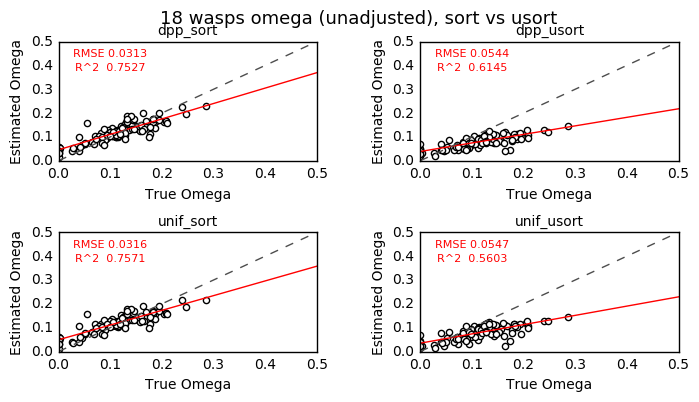

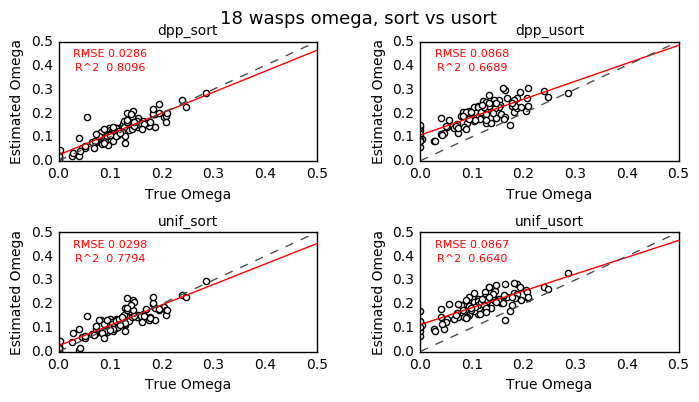

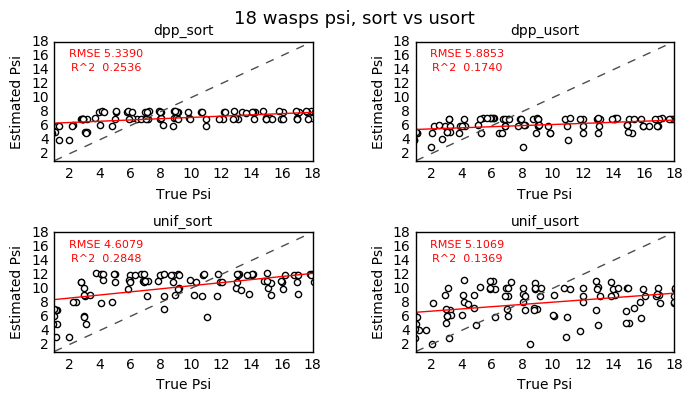

In [11]:
## Use column 6 to plot unadjusted omega values
plot2x2(PODS_OUTDIRS, 3, 6, 0.5, 0.5, "18 wasps omega (unadjusted), sort vs usort")
plot2x2(PODS_OUTDIRS, 3, 4, 0.5, 0.5, "18 wasps omega, sort vs usort")
plot2x2(PODS_OUTDIRS, 0, 1, 18, 18, "18 wasps psi, sort vs usort")

In [27]:
calc_ttests(PODS_OUTDIRS, 3, 4, "18 wasps omega, sort vs usort")
calc_ttests(PODS_OUTDIRS, 0, 1, "18 wasps psi, sort vs usort")

18 wasps omega, sort vs usort
('dpp_usort', 'unif_sort') 4.85135839242e-33
('dpp_usort', 'unif_usort') 0.957213800769
('dpp_usort', 'dpp_sort') 3.25277894968e-34
('unif_sort', 'unif_usort') 5.25811450053e-34
('unif_sort', 'dpp_sort') 0.654965668008
('unif_usort', 'dpp_sort') 3.30693677427e-35
18 wasps psi, sort vs usort
('dpp_usort', 'unif_sort') 0.101510672431
('dpp_usort', 'unif_usort') 0.291450506207
('dpp_usort', 'dpp_sort') 0.400966574593
('unif_sort', 'unif_usort') 0.569444740019
('unif_sort', 'dpp_sort') 0.455871243961
('unif_usort', 'dpp_sort') 0.847255374696


fish_dirichlet_sort fish_dirichlet_usort fish_uniform_sort fish_uniform_usort fish_dirichlet_sort fish_dirichlet_usort fish_uniform_sort fish_uniform_usort fish_dirichlet_sort fish_dirichlet_usort fish_uniform_sort fish_uniform_usort


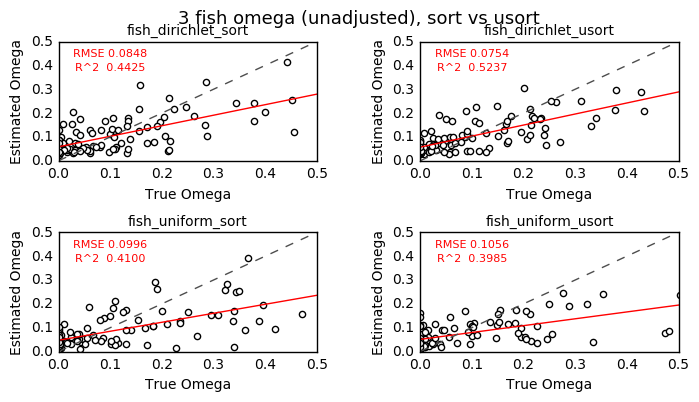

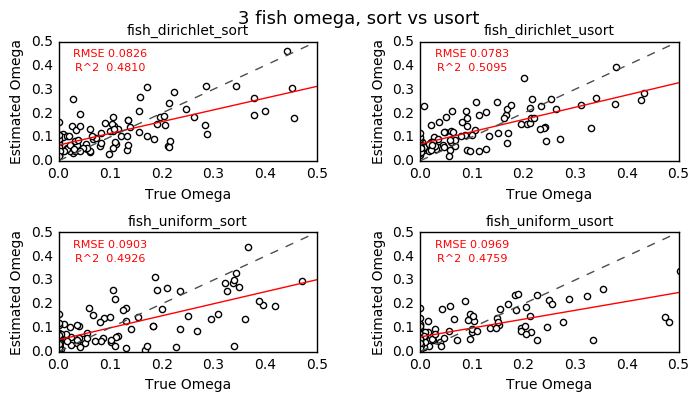

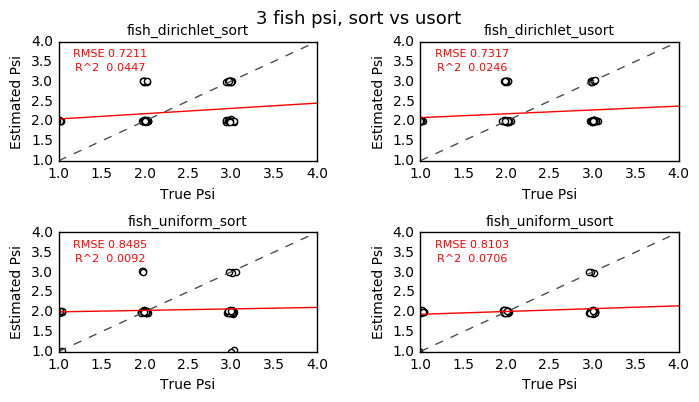

In [30]:
plot2x2(FISH_OUTDIRS, 3, 6, 0.5, 0.5, "3 fish omega (unadjusted), sort vs usort")
plot2x2(FISH_OUTDIRS, 3, 4, 0.5, 0.5, "3 fish omega, sort vs usort")
plot2x2(FISH_OUTDIRS, 0, 1, 4, 4, "3 fish psi, sort vs usort")

In [58]:
calc_ttests(FISH_OUTDIRS, 3, 4, "3 Fish omega, sort vs usort")
calc_ttests(FISH_OUTDIRS, 0, 1, "3 Fish psi, sort vs usort")

3 Fish omega, sort vs usort
('fish_dirichlet_usort', 'fish_uniform_sort') 0.678448647417
('fish_dirichlet_usort', 'fish_uniform_usort') 0.693330928521
('fish_dirichlet_usort', 'fish_dirichlet_sort') 0.825384068812
('fish_uniform_sort', 'fish_uniform_usort') 0.982401718276
('fish_uniform_sort', 'fish_dirichlet_sort') 0.559321187309
('fish_uniform_usort', 'fish_dirichlet_sort') 0.581833409173
3 Fish psi, sort vs usort
('fish_dirichlet_usort', 'fish_uniform_sort') 0.0547513370771
('fish_dirichlet_usort', 'fish_uniform_usort') 0.0829975964829
('fish_dirichlet_usort', 'fish_dirichlet_sort') 0.771805735551
('fish_uniform_sort', 'fish_uniform_usort') 0.811540341777
('fish_uniform_sort', 'fish_dirichlet_sort') 0.0265104376595
('fish_uniform_usort', 'fish_dirichlet_sort') 0.0415120981547


frogs_dirichlet_sort frogs_dirichlet_usort frogs_uniform_sort frogs_uniform_usort frogs_dirichlet_sort frogs_dirichlet_usort frogs_uniform_sort frogs_uniform_usort frogs_dirichlet_sort frogs_dirichlet_usort frogs_uniform_sort frogs_uniform_usort


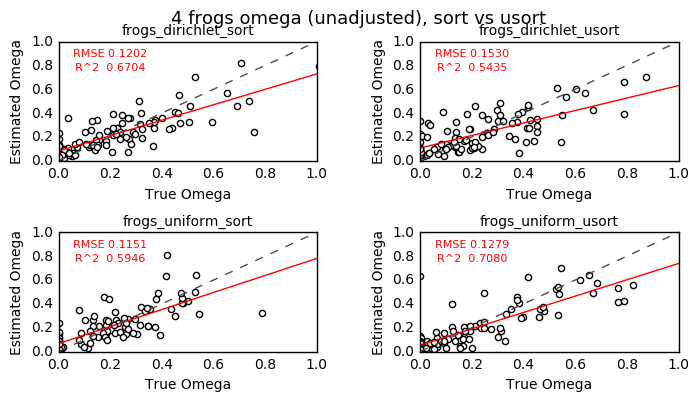

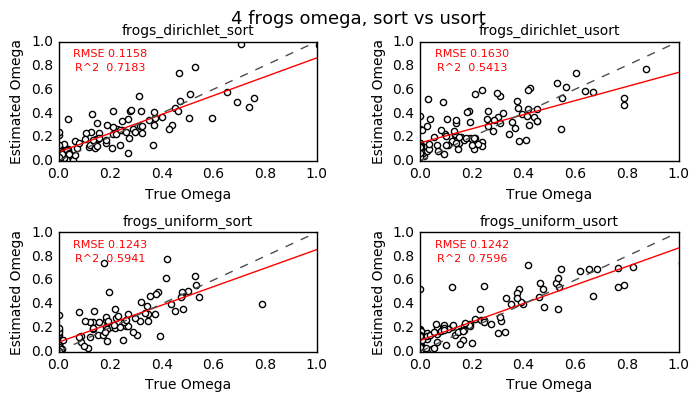

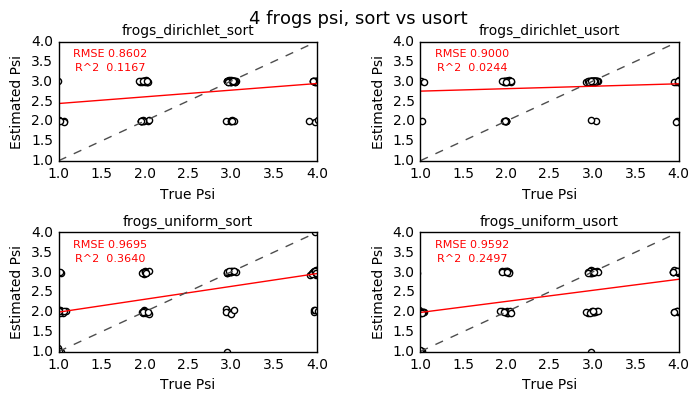

In [38]:
plot2x2(FROG_OUTDIRS, 3, 6, 1, 1, "4 frogs omega (unadjusted), sort vs usort")
plot2x2(FROG_OUTDIRS, 3, 4, 1, 1, "4 frogs omega, sort vs usort")
plot2x2(FROG_OUTDIRS, 0, 1, 4, 4, "4 frogs psi, sort vs usort")

In [34]:
calc_ttests(FROG_OUTDIRS, 3, 4, "3 Frogs omega, sort vs usort")
calc_ttests(FROG_OUTDIRS, 0, 1, "3 Frogs psi, sort vs usort")

3 Frogs omega, sort vs usort
('frogs_uniform_sort', 'frogs_dirichlet_usort') 0.00560991500608
('frogs_uniform_sort', 'frogs_dirichlet_sort') 0.786493720011
('frogs_uniform_sort', 'frogs_uniform_usort') 0.571976309592
('frogs_dirichlet_usort', 'frogs_dirichlet_sort') 0.00651156386856
('frogs_dirichlet_usort', 'frogs_uniform_usort') 0.0187121436983
('frogs_dirichlet_sort', 'frogs_uniform_usort') 0.738557601556
3 Frogs psi, sort vs usort
('frogs_uniform_sort', 'frogs_dirichlet_usort') 0.128770337412
('frogs_uniform_sort', 'frogs_dirichlet_sort') 0.0562418116186
('frogs_uniform_sort', 'frogs_uniform_usort') 0.635778994072
('frogs_dirichlet_usort', 'frogs_dirichlet_sort') 0.729507280422
('frogs_dirichlet_usort', 'frogs_uniform_usort') 0.305549682838
('frogs_dirichlet_sort', 'frogs_uniform_usort') 0.163266162583


dpp_sort dpp_usort unif_sort unif_usort dpp_sort dpp_usort unif_sort unif_usort


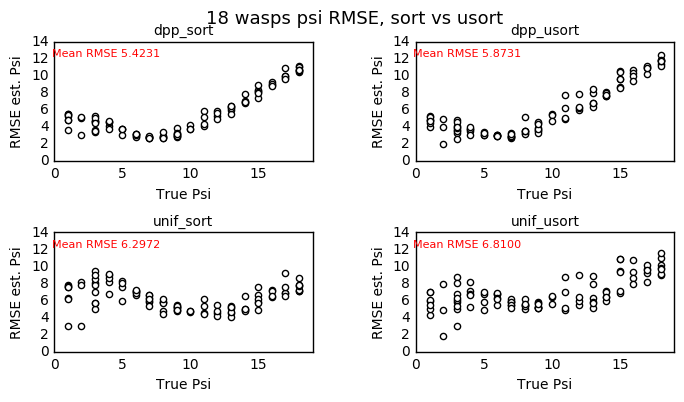

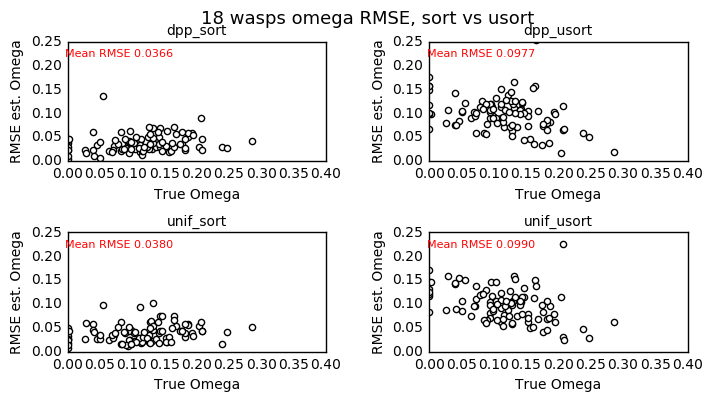

In [40]:
plotRMSE(PODS_OUTDIRS, 0, 2, 19, 14, "18 wasps psi RMSE, sort vs usort")
plotRMSE(PODS_OUTDIRS, 3, 5, .4, .25, "18 wasps omega RMSE, sort vs usort")

In [117]:
## For printing cells in tables bold if significant
def significant_bold(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    try:
        style = 'bold' if val[1] < 0.05 else 'normal'
    except:
        style = 'normal'
    return 'font-weight: %s' % style

In [124]:
models = []
for RESULTS_DIR in PODS_OUTDIRS:
    RUN_NAME = RESULTS_DIR.split("/")[-1]
    models.append(RUN_NAME)
df = pd.DataFrame(index=models, columns=models)
df = calc_fstats(PODS_OUTDIRS, 3, 4, "18 omega, sort vs usort", df)
df = calc_fstats(PODS_OUTDIRS, 0, 1, "18 psi, sort vs usort", df)
s = df.style.applymap(significant_bold)
s

18 omega, sort vs usort
(('dpp_usort', 'unif_sort'), 28.33054101639393, 2.7833106035788933e-07)
(('dpp_usort', 'unif_usort'), 0.048802687591818383, 0.8253898993836335)
(('dpp_usort', 'dpp_sort'), 33.692281814379236, 2.5637159940859704e-08)
(('unif_sort', 'unif_usort'), 26.401508215014537, 6.6775293208873827e-07)
(('unif_sort', 'dpp_sort'), 0.67287862585805214, 0.41304625836419173)
(('unif_usort', 'dpp_sort'), 31.695945058103131, 6.1810451269564573e-08)
18 psi, sort vs usort
(('dpp_usort', 'unif_sort'), 29.837767530924953, 1.4139093014603307e-07)
(('dpp_usort', 'unif_usort'), 7.9782940601752257, 0.0052236632167063984)
(('dpp_usort', 'dpp_sort'), 2.9614516888928484, 0.086849409503344716)
(('unif_sort', 'unif_usort'), 6.2541525988457902, 0.013209753954753092)
(('unif_sort', 'dpp_sort'), 12.294575203784838, 0.00056310570173723684)
(('unif_usort', 'dpp_sort'), 1.0767844616844648, 0.30069648121066322)


fish_dirichlet_sort fish_dirichlet_usort fish_uniform_sort fish_uniform_usort fish_dirichlet_sort fish_dirichlet_usort fish_uniform_sort fish_uniform_usort


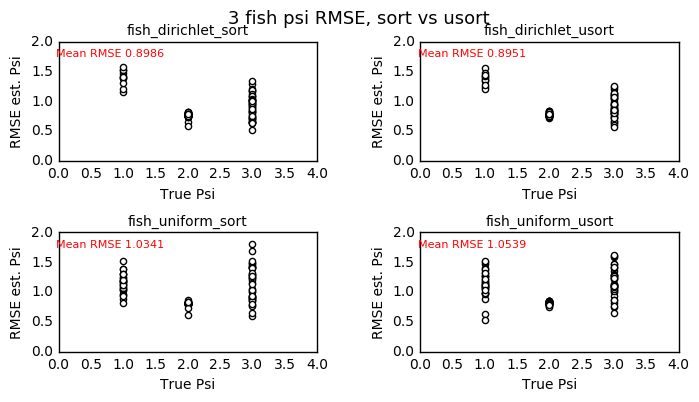

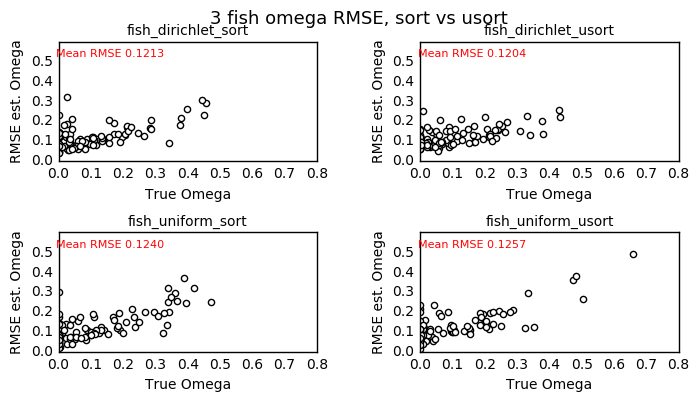

In [41]:
plotRMSE(FISH_OUTDIRS, 0, 2, 4, 2, "3 fish psi RMSE, sort vs usort")
plotRMSE(FISH_OUTDIRS, 3, 5, .8, .6, "3 fish omega RMSE, sort vs usort")

In [65]:
calc_fstats(FISH_OUTDIRS, 3, 4, "18 omega, sort vs usort")
calc_fstats(FISH_OUTDIRS, 0, 1, "18 psi, sort vs usort")

18 omega, sort vs usort
(('fish_dirichlet_usort', 'fish_uniform_sort'), 0.040177660034906582)
(('fish_dirichlet_usort', 'fish_uniform_usort'), 0.035428809489761896)
(('fish_dirichlet_usort', 'fish_dirichlet_sort'), 0.12515818757836156)
(('fish_uniform_sort', 'fish_uniform_usort'), 0.6936022397780327)
(('fish_uniform_sort', 'fish_dirichlet_sort'), 0.52171153837094419)
(('fish_uniform_usort', 'fish_dirichlet_sort'), 0.34344064493843529)
18 psi, sort vs usort
(('fish_dirichlet_usort', 'fish_uniform_sort'), 0.062731731927265)
(('fish_dirichlet_usort', 'fish_uniform_usort'), 0.0029193910180344909)
(('fish_dirichlet_usort', 'fish_dirichlet_sort'), 0.41942338759821096)
(('fish_uniform_sort', 'fish_uniform_usort'), 0.79166540848453693)
(('fish_uniform_sort', 'fish_dirichlet_sort'), 0.083077570851889132)
(('fish_uniform_usort', 'fish_dirichlet_sort'), 0.00458866652049565)


frogs_dirichlet_sort frogs_dirichlet_usort frogs_uniform_sort frogs_uniform_usort frogs_dirichlet_sort frogs_dirichlet_usort frogs_uniform_sort frogs_uniform_usort


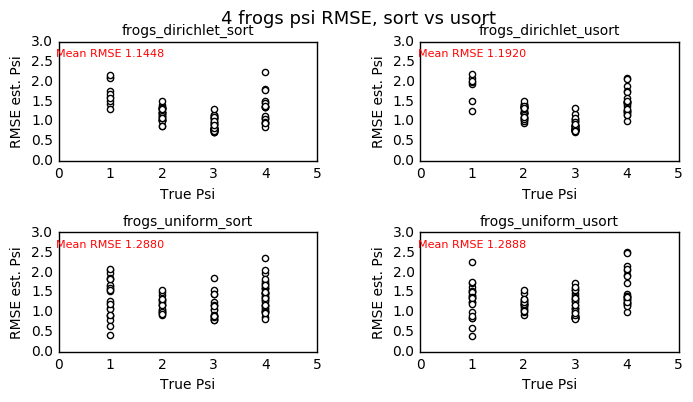

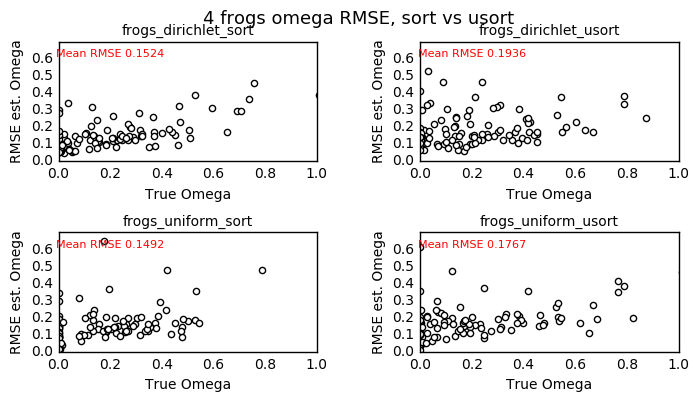

In [42]:
plotRMSE(FROG_OUTDIRS, 0, 2, 5, 3, "4 frogs psi RMSE, sort vs usort")
plotRMSE(FROG_OUTDIRS, 3, 5, 1, .7, "4 frogs omega RMSE, sort vs usort")

In [64]:
calc_fstats(FROG_OUTDIRS, 3, 4, "18 omega, sort vs usort")
calc_fstats(FROG_OUTDIRS, 0, 1, "18 psi, sort vs usort")

18 omega, sort vs usort
(('frogs_uniform_sort', 'frogs_dirichlet_usort'), 0.088440504903602418)
(('frogs_uniform_sort', 'frogs_dirichlet_sort'), 0.77627917713148065)
(('frogs_uniform_sort', 'frogs_uniform_usort'), 0.65733346209241472)
(('frogs_dirichlet_usort', 'frogs_dirichlet_sort'), 0.026089010039235489)
(('frogs_dirichlet_usort', 'frogs_uniform_usort'), 0.027787788168444443)
(('frogs_dirichlet_sort', 'frogs_uniform_usort'), 0.82541232637549222)
18 psi, sort vs usort
(('frogs_uniform_sort', 'frogs_dirichlet_usort'), 0.037850184937385553)
(('frogs_uniform_sort', 'frogs_dirichlet_sort'), 0.062971892818691519)
(('frogs_uniform_sort', 'frogs_uniform_usort'), 0.28645023626769917)
(('frogs_dirichlet_usort', 'frogs_dirichlet_sort'), 0.71499804650819154)
(('frogs_dirichlet_usort', 'frogs_uniform_usort'), 0.33624101700635922)
(('frogs_dirichlet_sort', 'frogs_uniform_usort'), 0.4958483737628645)


## Testing against the wrong prior
This is what happens when you use dpp pods with uniform prior and vice versa.

In [126]:
MODELS = ["dirichlet_sort", "dirichlet_usort", "uniform_sort", "uniform_usort"]
BAD_DIR = "/Volumes/WorkDrive/msbayes-buffering/hickerlab-repository/msbayes-buffering/data/empirical/results/results-badPrior/"
FISH_BADDIRS = [BAD_DIR + "fish_" + x for x in MODELS]
FROG_BADDIRS = [BAD_DIR + "frogs_" + x for x in MODELS]

fish_dirichlet_sort fish_dirichlet_usort fish_uniform_sort fish_uniform_usort fish_dirichlet_sort fish_dirichlet_usort fish_uniform_sort fish_uniform_usort


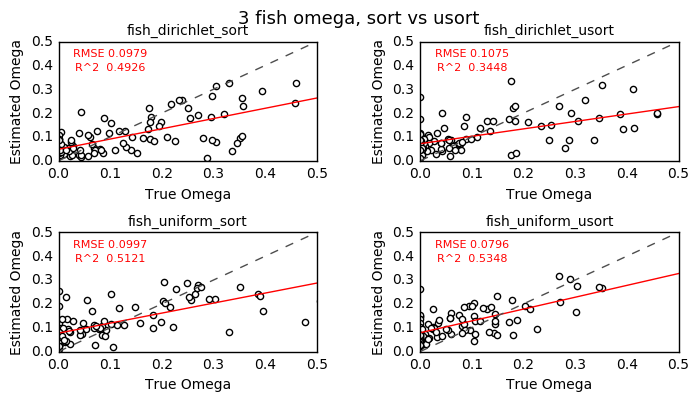

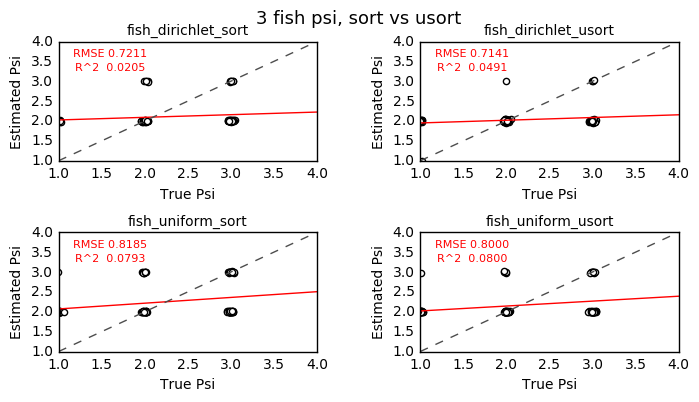

In [127]:
plot2x2(FISH_BADDIRS, 3, 4, 0.5, 0.5, "3 fish omega, sort vs usort")
plot2x2(FISH_BADDIRS, 0, 1, 4, 4, "3 fish psi, sort vs usort")

frogs_dirichlet_sort frogs_dirichlet_usort frogs_uniform_sort frogs_uniform_usort frogs_dirichlet_sort frogs_dirichlet_usort frogs_uniform_sort frogs_uniform_usort


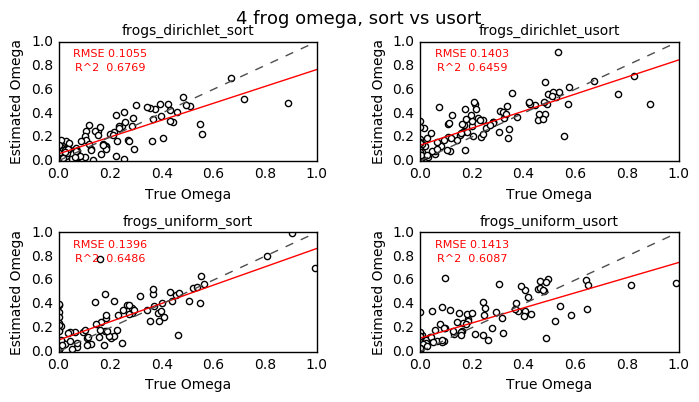

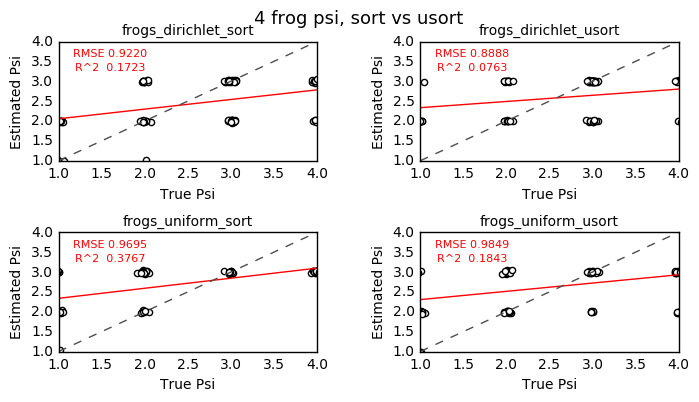

In [128]:
plot2x2(FROG_BADDIRS, 3, 4, 1, 1, "4 frog omega, sort vs usort")
plot2x2(FROG_BADDIRS, 0, 1, 4, 4, "4 frog psi, sort vs usort")

http://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way
